## RED NEURONAL PARA DETECCIÓN DE EMOCIONES




1. INTRODUCCIÓN

    En este proyecto blablabla


2. CARGA DE DATOS


In [ ]:
#Importacion de modulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os 
from PIL import Image


Emoción: angry, Tamaño Carpeta: 3995, Tamaño Imagen: (48, 48), capas -> 1
Emoción: fear, Tamaño Carpeta: 4097, Tamaño Imagen: (48, 48), capas -> 1
Emoción: happy, Tamaño Carpeta: 7215, Tamaño Imagen: (48, 48), capas -> 1
Emoción: neutral, Tamaño Carpeta: 4965, Tamaño Imagen: (48, 48), capas -> 1
Emoción: sad, Tamaño Carpeta: 4830, Tamaño Imagen: (48, 48), capas -> 1
Emoción: surprise, Tamaño Carpeta: 3171, Tamaño Imagen: (48, 48), capas -> 1


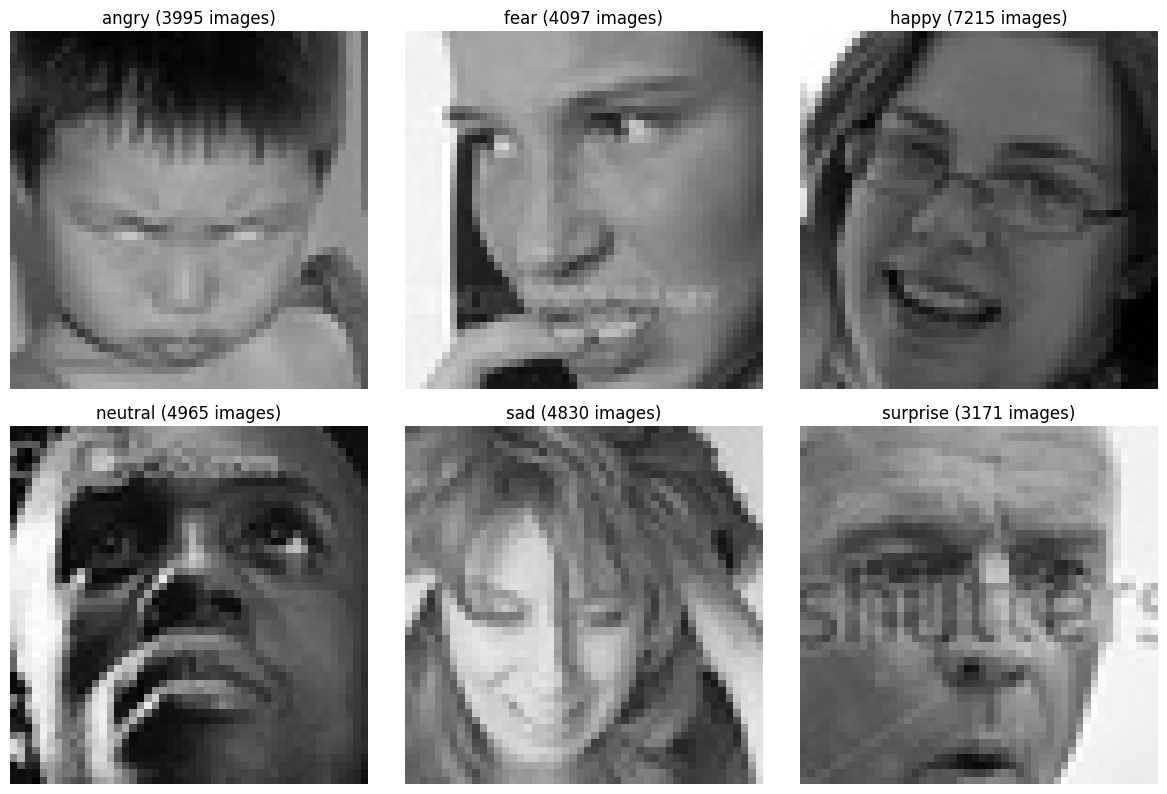

In [ ]:
# Mostramos tamaño y datos sobre el dataset

#Hemos quitado una carpeta del dataset original- disgust, por tener muchos menos ejemplos (<500)

dataset_path = 'data'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

plt.figure(figsize=(12, 12))
for idx, emotion in enumerate(os.listdir(train_path)):
    emotion_folder = os.path.join(train_path, emotion)
    
    image_name = os.listdir(emotion_folder)[0]
    image_path = os.path.join(emotion_folder, image_name)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3, 3, idx + 1)
    plt.imshow(image_rgb)
    plt.title(f"{emotion} ({len(os.listdir(emotion_folder))} images)")
    plt.axis('off')
    
    with Image.open(image_path) as img:
        print(f"Emoción: {emotion}, Tamaño Carpeta: {len(os.listdir(emotion_folder))}, Tamaño Imagen: {img.size}, capas -> {img.layers}")

plt.tight_layout()
plt.show()

3. PRIMERA RED


In [3]:
# Imports
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [60]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf

input_layer = Input(shape=(48, 48, 1)) 

#ResNet50 preentrenado como base
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(48, 48, 3)))

for layer in base_model.layers:
    layer.trainable = False


# Cambiar las capas del modelo para que trabajen con escala de grises
x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(input_layer)  # Convertir a 3 canales
x = base_model(x)  # Pasar la imagen convertida a ResNet50
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)  #Aumentar el número de neuronas
x = Dropout(0.5)(x)  #dropout para evitar sobreajuste
output_layer = Dense(6, activation='softmax')(x)  # 6 clases

model = Model(inputs=input_layer, outputs=output_layer)

for layer in model.layers[-20:]: #solo podremos modificar las ultimas capas del modelo preentrenado
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Generador de imágenes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

#generadores
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(48, 48),  # Mantener el tamaño de la imagen
    color_mode='grayscale',  # Usar escala de grises
    batch_size=32,  # Aumentar tamaño de lote
    class_mode='sparse'
)

# Definir callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model_resnet.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()




Found 28273 images belonging to 6 classes.
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 3)         6         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_46 (Dens

In [61]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[lr_reduction, checkpoint, early_stopping],
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
883/883 [==============================] - ETA: 0s - loss: 1.9041 - accuracy: 0.2729

C:\Users\PC GAMER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


883/883 [==============================] - 743s 823ms/step - loss: 1.9041 - accuracy: 0.2729 - val_loss: 1.8016 - val_accuracy: 0.2093 - lr: 1.0000e-04
Epoch 2/10
883/883 [==============================] - 724s 820ms/step - loss: 1.5454 - accuracy: 0.3846 - val_loss: 1.4320 - val_accuracy: 0.4407 - lr: 1.0000e-04
Epoch 3/10
883/883 [==============================] - 719s 814ms/step - loss: 1.4311 - accuracy: 0.4370 - val_loss: 1.8427 - val_accuracy: 0.2225 - lr: 1.0000e-04
Epoch 4/10
883/883 [==============================] - 719s 815ms/step - loss: 1.3340 - accuracy: 0.4797 - val_loss: 1.5454 - val_accuracy: 0.4535 - lr: 5.0000e-05
Epoch 5/10
883/883 [==============================] - 717s 812ms/step - loss: 1.2609 - accuracy: 0.5106 - val_loss: 1.3348 - val_accuracy: 0.5149 - lr: 2.5000e-05
Epoch 6/10
883/883 [==============================] - 716s 811ms/step - loss: 1.2263 - accuracy: 0.5295 - val_loss: 1.2165 - val_accuracy: 0.5252 - lr: 2.5000e-05
Epoch 7/10
883/883 [=============

In [84]:
test_dir = 'data/test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%')


Found 7067 images belonging to 6 classes.
220/220 [==============================] - 70s 319ms/step - loss: 1.1028 - accuracy: 0.5760
Precisión en el conjunto de prueba: 57.60%


4. SEGUNDA RED

In [64]:
#IMPORTS
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [74]:
#PREPROCESAMIENTO DE LAS IMAGENES
# USAMOS UNA FUNCION PARA TODAS LAS IMAGENES

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError(f"Image not found at the path: {image_path}")
    
    # Resaltar bordes ( sobre todo horizontales)
    sobel_horizontal = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_horizontal = np.clip(sobel_horizontal, 0, 255).astype(np.uint8)

    # Aumenta contraste con CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)

    #sharpen
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(clahe_image, -1, sharpening_kernel)

    #reduce ruido
    blurred_image = cv2.GaussianBlur(sharpened_image, (3, 3), sigmaX=1)

    #combina todos los features 
    processed_image = cv2.addWeighted(sobel_horizontal, 0.5, blurred_image, 0.5, 0)

    return processed_image



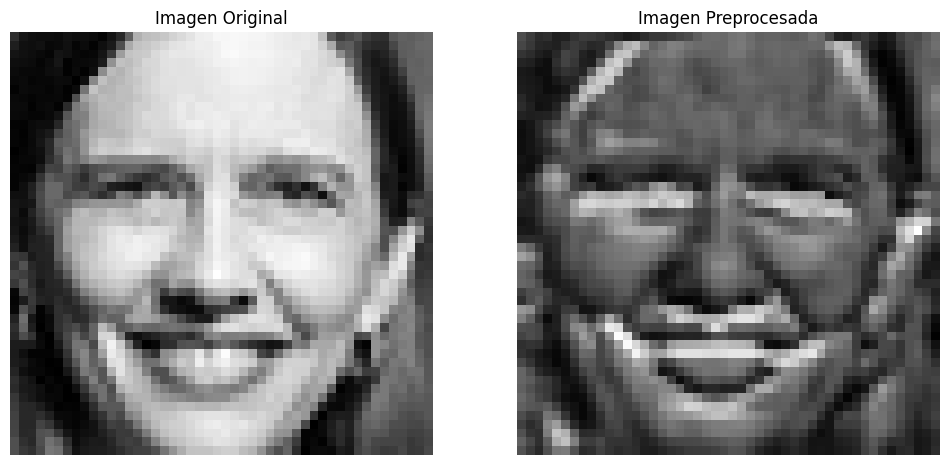

In [75]:
train_dir = 'data/train'

example_image_path = os.path.join(train_dir, 'happy', os.listdir(os.path.join(train_dir, 'happy'))[20])
processed_image = preprocess_image(example_image_path)

original_image = cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Imagen Preprocesada')
plt.axis('off')
plt.show()

In [77]:
#RNN SIMPLE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def create_simple_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularización
    model.add(Dense(6, activation='softmax'))  # 6 clases (sin 'disgust')
    
    return model

input_shape = (48, 48, 1)  
simple_model = create_simple_model(input_shape)

simple_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale', 
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
)

history_simple = simple_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Epoch 1/20
706/706 [==============================] - 36s 49ms/step - loss: 1.6784 - accuracy: 0.3040 - val_loss: 1.5722 - val_accuracy: 0.3691
Epoch 2/20
706/706 [==============================] - 34s 48ms/step - loss: 1.5449 - accuracy: 0.3811 - val_loss: 1.4839 - val_accuracy: 0.4103
Epoch 3/20
706/706 [==============================] - 34s 48ms/step - loss: 1.4836 - accuracy: 0.4096 - val_loss: 1.4576 - val_accuracy: 0.4288
Epoch 4/20
706/706 [==============================] - 34s 49ms/step - loss: 1.4399 - accuracy: 0.4272 - val_loss: 1.3999 - val_accuracy: 0.4561
Epoch 5/20
706/706 [==============================] - 34s 48ms/step - loss: 1.4082 - accuracy: 0.4438 - val_loss: 1.3586 - val_accuracy: 0.4627
Epoch 6/20
706/706 [==============================] - 33s 47ms/step - loss: 1.3911 - accuracy: 0.4484 - val_loss: 1.3475 - val_accuracy: 0.4631
Epoch 7/20
706/706 [==============================]

In [79]:
import os
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#cargar y preprocesar imágenes de test
def load_and_preprocess_test_images(test_dir):
    images = []
    labels = []
    
    class_labels = os.listdir(test_dir)
    
    for label in class_labels:
        class_path = os.path.join(test_dir, label)
        
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                image = preprocess_image(image_path)
                images.append(image) 
                labels.append(class_labels.index(label))  
            except ValueError as e:
                print(e)  

    return np.array(images), np.array(labels)

test_dir = 'data/test'
X_test, y_test = load_and_preprocess_test_images(test_dir)


In [83]:
from sklearn.metrics import precision_score, accuracy_score


# Ensure images have the correct shape for the model
X_test = X_test.reshape(-1, 48, 48, 1)  # Add channel dimension

# Make predictions
y_pred = simple_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the precision and accuracy
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")


221/221 [==============================] - 1s 7ms/step
Precision: 0.3676
Accuracy: 0.2831


5. RESULTADOS

5. CONCLUSIÓN